# learning rate decay 
网络结构由之前我们定义的类ShallowNet构建
为了评估learning rate decay对网络过拟合带来的改进，网络中添加了learning rate decay模块

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imgpreprocess.imgtoarray import ImgToArray
from imgpreprocess.imgresize import ImgResize
from imgdatasets.imgload import ImgLoad
from nn.conv.shallownet import ShallowNet
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse

from keras.callbacks import LearningRateScheduler

这里定义我们的learning rate decay调整函数，并将其作为模型训练时的回调函数使用

In [2]:
def lr_step_decay(epoch):
    initAlpha = 0.005
    factor = 0.9
    dropEvery = 5
    
    alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))
    print("#epoch:{}".format(epoch))
    
    return float(alpha)

In [3]:
'''
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True,
               help="path to input dataset")
ap.add_argument("-m", "--model", required=True,
               help="path to output model")
args = vars(ap.parse_args())
'''

'\nap = argparse.ArgumentParser()\nap.add_argument("-d", "--dataset", required=True,\n               help="path to input dataset")\nap.add_argument("-m", "--model", required=True,\n               help="path to output model")\nargs = vars(ap.parse_args())\n'

In [4]:
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(args["dataset"]))
imagePaths = list(paths.list_images("../imgdatasets/animals3"))
print("[INFO] load images dnoe...")

[INFO] loading images...
[INFO] load images dnoe...


In [5]:
print("[INFO] images preprocessing...")
resize = ImgResize(32, 32)
imgtoarray = ImgToArray()

imgload = ImgLoad(preprocessors=[resize, imgtoarray])
(data, labels) = imgload.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0
print("[INFO] images preprocess done")

[INFO] images preprocessing...
[INFO] images preprocess done


In [6]:
print("[INFO] train test dataset split")
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.25, random_state=42, stratify=labels)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

[INFO] train test dataset split


In [7]:
print("[INFO] compiling model...")
opt = SGD(lr=0.005)
model = ShallowNet.build(width=32, height=32, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [8]:
print("[INFO] trainning network...")
callbacks = [LearningRateScheduler(lr_step_decay)]

H = model.fit(trainX, trainY, validation_data=(testX, testY),
    batch_size=32, epochs=50, callbacks=callbacks, verbose=1)

[INFO] trainning network...
#epoch:0
Epoch 1/50
210/210 [==============================] - 11s 50ms/step - loss: 0.9476 - accuracy: 0.5656 - val_loss: 0.9010 - val_accuracy: 0.6041 - lr: 0.0050
#epoch:1
Epoch 2/50
210/210 [==============================] - 11s 55ms/step - loss: 0.8867 - accuracy: 0.6120 - val_loss: 0.8984 - val_accuracy: 0.5840 - lr: 0.0050
#epoch:2
Epoch 3/50
210/210 [==============================] - 12s 56ms/step - loss: 0.8558 - accuracy: 0.6302 - val_loss: 0.8556 - val_accuracy: 0.6386 - lr: 0.0050
#epoch:3
Epoch 4/50
210/210 [==============================] - 12s 55ms/step - loss: 0.8359 - accuracy: 0.6414 - val_loss: 0.8399 - val_accuracy: 0.6413 - lr: 0.0050
#epoch:4
Epoch 5/50
210/210 [==============================] - 10s 48ms/step - loss: 0.8230 - accuracy: 0.6450 - val_loss: 0.8536 - val_accuracy: 0.6314 - lr: 0.0045
#epoch:5
Epoch 6/50
210/210 [==============================] - 11s 52ms/step - loss: 0.8097 - accuracy: 0.6525 - val_loss: 0.8202 - val_accura

#epoch:49
Epoch 50/50
210/210 [==============================] - 11s 51ms/step - loss: 0.5582 - accuracy: 0.7818 - val_loss: 0.6854 - val_accuracy: 0.7219 - lr: 0.0017


In [9]:
print("[INFO] serializing network...")
#model.save(args["model"])
model.save("shallownet_animal3_weights.hdf5")

[INFO] serializing network...


In [10]:
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1),
    target_names=[str(x) for x in lb.classes_]))

[INFO] evaluating network...
              precision    recall  f1-score   support

        cane       0.72      0.91      0.80      1216
     cavallo       0.73      0.59      0.65       656
    elefante       0.71      0.33      0.45       361

    accuracy                           0.72      2233
   macro avg       0.72      0.61      0.64      2233
weighted avg       0.72      0.72      0.70      2233



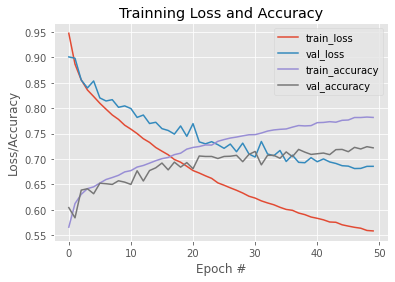

In [11]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 50), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 50), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 50), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, 50), H.history["val_accuracy"], label="val_accuracy")
plt.title("Trainning Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("./results/shallownet_animals3_trainning_result_lr_decay")